In [ ]:
# https://www.kaggle.com/code/mahwiz/stock-market-prediction

In [7]:
import pandas as pd 
import numpy as np
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [43]:
# fetching data from Yahoo Finance
company = '^NSEI'

In [44]:
start = dt.datetime(2004, 1, 1)
end = dt.datetime(2022, 6, 28)

data = web.DataReader(company, 'yahoo', start, end)

#Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [45]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-09-17,4549.049805,4482.850098,4518.450195,4494.649902,0.0,4494.649902
2007-09-18,4551.799805,4481.549805,4494.100098,4546.200195,0.0,4546.200195
2007-09-19,4739.000000,4550.250000,4550.250000,4732.350098,0.0,4732.350098
2007-09-20,4760.850098,4721.149902,4734.850098,4747.549805,0.0,4747.549805
2007-09-21,4855.700195,4733.700195,4752.950195,4837.549805,0.0,4837.549805
...,...,...,...,...,...,...
2022-06-22,15565.400391,15385.950195,15545.650391,15413.299805,220900.0,15413.299805
2022-06-23,15628.450195,15367.500000,15451.549805,15556.650391,259200.0,15556.650391
2022-06-24,15749.250000,15619.450195,15657.400391,15699.250000,219600.0,15699.250000


In [46]:
#build the Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
112/112 [==============================] - 9s 84ms/step - loss: 0.0106: 1s 
Epoch 2/25
112/112 [==============================] - 10s 86ms/step - loss: 0.0021
Epoch 3/25
112/112 [==============================] - 9s 85ms/step - loss: 0.0021
Epoch 4/25
112/112 [==============================] - 10s 86ms/step - loss: 0.0017
Epoch 5/25
112/112 [==============================] - 10s 87ms/step - loss: 0.0016 0s - loss: 0.
Epoch 6/25
112/112 [==============================] - 10s 87ms/step - loss: 0.0016
Epoch 7/25
112/112 [==============================] - 10s 88ms/step - loss: 0.0016
Epoch 8/25
112/112 [==============================] - 10s 88ms/step - loss: 0.0013
Epoch 9/25
112/112 [==============================] - 10s 86ms/step - loss: 0.0013
Epoch 10/25
112/112 [==============================] - 10s 86ms/step - loss: 0.0012 1s -
Epoch 11/25
112/112 [==============================] - 10s 87ms/step - loss: 0.0013
Epoch 12/25
112/112 [==============================] - 10s 87ms

In [47]:
# Testing the model accuracy on existing data
# load Test Data
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()
test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

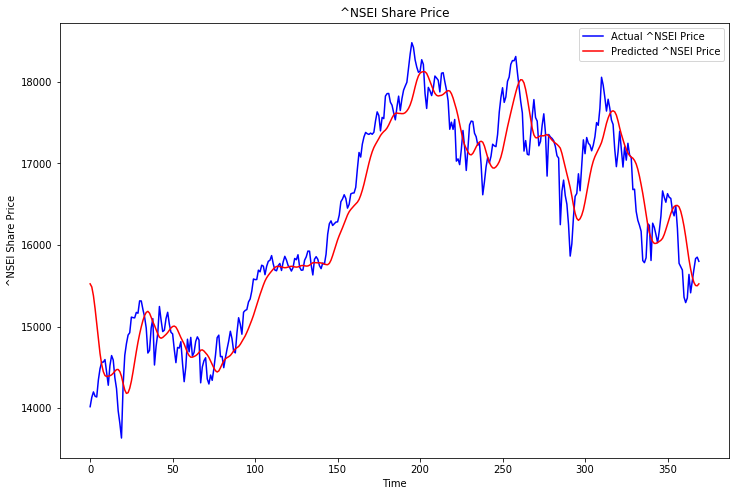

In [48]:
# Make prediction on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Plot the test prediction
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color='blue', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='red', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [49]:
# Predict Next day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction : {prediction}')

Prediction : [[15562.475]]
